In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
if params.feat_sel == 'auto': # automatic feature selection, based on feature importance notebook
    
    df_feat_sel = pd.read_csv(params.feat_sel_auto_csv, index_col=0, parse_dates=True)
    
elif params.feat_sel == 'man': # alternative manual feature selection, based on the features selected in the params.py
    
    df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,atr_ratio,atr_ratio_sma,vol_15,bb_width_20,r_15,rsi,stoch_k_14,eng_ma,bid,ask,signal
2004-01-02 13:07:00,-0.996380,-0.987015,-1.005076,-0.943230,-0.009476,-2.476841,-1.552562,-0.001209,0.763698,0.764840,0.014975
2004-01-02 13:08:00,-0.994579,-0.986828,-1.001603,-0.937271,-0.017401,-2.476841,-1.552562,-0.001209,0.763681,0.764824,0.016217
2004-01-02 13:09:00,-0.992906,-0.986557,-0.999187,-0.930276,-0.025327,-2.476841,-1.552562,-0.001209,0.763664,0.764807,0.017566
2004-01-02 13:10:00,-0.991353,-0.986209,-0.997370,-0.922523,-0.033253,-2.476841,-1.552562,-0.001209,0.763647,0.764790,0.019028
2004-01-02 13:11:00,-0.989911,-0.985789,-0.995973,-0.914218,-0.041178,-2.476841,-1.552562,-0.001209,0.763631,0.764773,0.020611
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.582507,0.182057,0.348747,0.119570,1.315228,0.811095,0.354296,12.115664,196.667400,196.962600,0.305243
2025-06-18 20:57:00,0.641713,0.207647,0.391507,0.184714,1.113128,0.539711,0.426843,12.401440,196.527500,196.822500,0.093820
2025-06-18 20:58:00,0.574130,0.230765,0.392142,0.238300,0.827243,0.530165,0.381683,12.401440,196.522500,196.817500,0.000061
2025-06-18 20:59:00,0.695123,0.261866,0.692251,0.242399,-0.093724,-0.151391,-0.182061,9.257911,196.092800,196.387200,0.000076


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_15', 'rsi', 'stoch_k_14', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2414427, 60, 8]) (samples, look_back, features)
  y_sig     = torch.Size([2414427]) (samples,)
  y_ret     = torch.Size([2414427]) (samples,)
  raw_close = torch.Size([2414427])
  raw_bid   = torch.Size([2414427])
  raw_ask   = torch.Size([2414427])
  end_times = (2414427,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1696435, 60, 8])
  y_sig_tr, y_ret_tr = torch.Size([1696435]) torch.Size([1696435])
  X_val = torch.Size([353133, 60, 8])
  y_sig_val, y_ret_val = torch.Size([353133]) torch.Size([353133])
  X_te  = torch.Size([364859, 60, 8])
  y_sig_te, y_ret_te = torch.Size([364859]) torch.Size([364859])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(8, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.2, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.25, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# # -----------------------------------------------------------------------------
# # Compute plateau_sched timing parameters
# # -----------------------------------------------------------------------------
# # Total training samples = total windows in X_tr (one window per row)
# n_train_samples = X_tr.shape[0]

# # How many optimizer steps (day‐bundles) constitute one epoch?
# steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.418458,  val = 0.411622

Train target stats:
  mean = 0.2851,  var = 0.0938,  std = 0.3063
Train mean‐predictor baseline:
  RMSE_baseline = 0.306326
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2855,  var = 0.0879,  std = 0.2965
Validation mean‐predictor baseline:
  RMSE_baseline = 0.296508
  R²_baseline   = 0.00



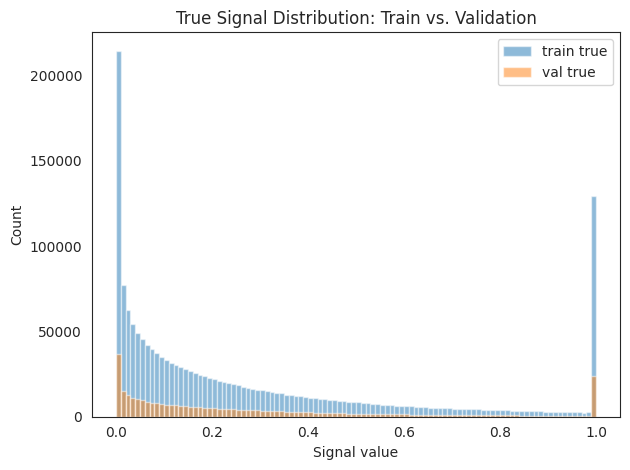

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3808 unique trading days per epoch.



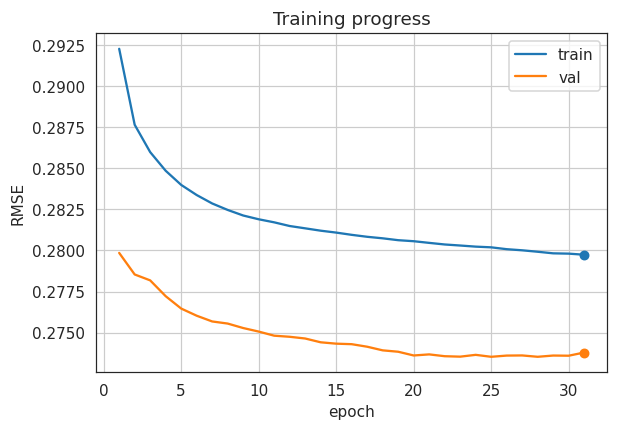

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2923 MAE=0.2315 R2=0.0903 | "B": Acc=0.2462 Prec=0.2352 Rec=0.9865 F1=0.3799 AUROC=0.5451
VALID→ "R": RMSE=0.2799 MAE=0.2162 R2=0.1092 | "B": Acc=0.2266 Prec=0.2248 Rec=0.9842 F1=0.3661 AUROC=0.5006


Epoch 2:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2877 MAE=0.2289 R2=0.1189 | "B": Acc=0.2523 Prec=0.2366 Rec=0.9854 F1=0.3815 AUROC=0.5840
VALID→ "R": RMSE=0.2785 MAE=0.2157 R2=0.1175 | "B": Acc=0.2273 Prec=0.2262 Rec=0.9939 F1=0.3685 AUROC=0.5357


Epoch 3:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2860 MAE=0.2274 R2=0.1291 | "B": Acc=0.2526 Prec=0.2368 Rec=0.9867 F1=0.3820 AUROC=0.5916
VALID→ "R": RMSE=0.2782 MAE=0.2158 R2=0.1198 | "B": Acc=0.2275 Prec=0.2269 Rec=0.9990 F1=0.3698 AUROC=0.5418


Epoch 4:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2849 MAE=0.2262 R2=0.1360 | "B": Acc=0.2544 Prec=0.2371 Rec=0.9853 F1=0.3822 AUROC=0.5943
VALID→ "R": RMSE=0.2772 MAE=0.2156 R2=0.1259 | "B": Acc=0.2276 Prec=0.2270 Rec=0.9998 F1=0.3700 AUROC=0.5501


Epoch 5:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2840 MAE=0.2254 R2=0.1412 | "B": Acc=0.2563 Prec=0.2375 Rec=0.9848 F1=0.3826 AUROC=0.5917
VALID→ "R": RMSE=0.2765 MAE=0.2150 R2=0.1306 | "B": Acc=0.2277 Prec=0.2270 Rec=0.9999 F1=0.3701 AUROC=0.5516


Epoch 6:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2834 MAE=0.2247 R2=0.1449 | "B": Acc=0.2585 Prec=0.2378 Rec=0.9832 F1=0.3830 AUROC=0.5943
VALID→ "R": RMSE=0.2760 MAE=0.2145 R2=0.1334 | "B": Acc=0.2277 Prec=0.2270 Rec=0.9998 F1=0.3700 AUROC=0.5626


Epoch 7:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2829 MAE=0.2242 R2=0.1480 | "B": Acc=0.2610 Prec=0.2382 Rec=0.9816 F1=0.3834 AUROC=0.5962
VALID→ "R": RMSE=0.2757 MAE=0.2141 R2=0.1356 | "B": Acc=0.2276 Prec=0.2268 Rec=0.9978 F1=0.3695 AUROC=0.5739


Epoch 8:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2825 MAE=0.2238 R2=0.1504 | "B": Acc=0.2647 Prec=0.2387 Rec=0.9785 F1=0.3838 AUROC=0.5980
VALID→ "R": RMSE=0.2755 MAE=0.2139 R2=0.1364 | "B": Acc=0.2275 Prec=0.2264 Rec=0.9954 F1=0.3689 AUROC=0.5779


Epoch 9:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2821 MAE=0.2234 R2=0.1524 | "B": Acc=0.2703 Prec=0.2398 Rec=0.9760 F1=0.3850 AUROC=0.6044
VALID→ "R": RMSE=0.2753 MAE=0.2136 R2=0.1381 | "B": Acc=0.2274 Prec=0.2261 Rec=0.9930 F1=0.3684 AUROC=0.5843


Epoch 10:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2819 MAE=0.2232 R2=0.1538 | "B": Acc=0.2702 Prec=0.2397 Rec=0.9753 F1=0.3848 AUROC=0.6022
VALID→ "R": RMSE=0.2751 MAE=0.2132 R2=0.1394 | "B": Acc=0.2274 Prec=0.2260 Rec=0.9920 F1=0.3681 AUROC=0.5903


Epoch 11:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2817 MAE=0.2230 R2=0.1549 | "B": Acc=0.2744 Prec=0.2405 Rec=0.9730 F1=0.3857 AUROC=0.6075
VALID→ "R": RMSE=0.2748 MAE=0.2129 R2=0.1410 | "B": Acc=0.2273 Prec=0.2257 Rec=0.9900 F1=0.3676 AUROC=0.5907


Epoch 12:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2815 MAE=0.2229 R2=0.1563 | "B": Acc=0.2799 Prec=0.2415 Rec=0.9701 F1=0.3867 AUROC=0.6125
VALID→ "R": RMSE=0.2747 MAE=0.2129 R2=0.1414 | "B": Acc=0.2273 Prec=0.2255 Rec=0.9886 F1=0.3673 AUROC=0.5924


Epoch 13:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2813 MAE=0.2228 R2=0.1571 | "B": Acc=0.2792 Prec=0.2413 Rec=0.9698 F1=0.3865 AUROC=0.6113
VALID→ "R": RMSE=0.2746 MAE=0.2126 R2=0.1421 | "B": Acc=0.2273 Prec=0.2254 Rec=0.9875 F1=0.3670 AUROC=0.5958


Epoch 14:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2812 MAE=0.2226 R2=0.1580 | "B": Acc=0.2851 Prec=0.2425 Rec=0.9673 F1=0.3878 AUROC=0.6149
VALID→ "R": RMSE=0.2744 MAE=0.2124 R2=0.1435 | "B": Acc=0.2272 Prec=0.2252 Rec=0.9857 F1=0.3666 AUROC=0.5971


Epoch 15:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2811 MAE=0.2225 R2=0.1587 | "B": Acc=0.2914 Prec=0.2435 Rec=0.9624 F1=0.3887 AUROC=0.6173
VALID→ "R": RMSE=0.2743 MAE=0.2122 R2=0.1440 | "B": Acc=0.2274 Prec=0.2249 Rec=0.9834 F1=0.3661 AUROC=0.5966


Epoch 16:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2810 MAE=0.2224 R2=0.1595 | "B": Acc=0.2926 Prec=0.2435 Rec=0.9600 F1=0.3885 AUROC=0.6168
VALID→ "R": RMSE=0.2743 MAE=0.2122 R2=0.1442 | "B": Acc=0.2273 Prec=0.2246 Rec=0.9814 F1=0.3656 AUROC=0.5909


Epoch 17:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2808 MAE=0.2222 R2=0.1602 | "B": Acc=0.2937 Prec=0.2438 Rec=0.9601 F1=0.3889 AUROC=0.6188
VALID→ "R": RMSE=0.2741 MAE=0.2121 R2=0.1452 | "B": Acc=0.2276 Prec=0.2243 Rec=0.9783 F1=0.3649 AUROC=0.5897


Epoch 18:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2807 MAE=0.2221 R2=0.1608 | "B": Acc=0.2995 Prec=0.2450 Rec=0.9574 F1=0.3902 AUROC=0.6216
VALID→ "R": RMSE=0.2739 MAE=0.2118 R2=0.1466 | "B": Acc=0.2280 Prec=0.2241 Rec=0.9761 F1=0.3646 AUROC=0.5908


Epoch 19:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2806 MAE=0.2220 R2=0.1615 | "B": Acc=0.3005 Prec=0.2450 Rec=0.9556 F1=0.3901 AUROC=0.6193
VALID→ "R": RMSE=0.2738 MAE=0.2115 R2=0.1471 | "B": Acc=0.2274 Prec=0.2236 Rec=0.9727 F1=0.3636 AUROC=0.5830


Epoch 20:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2806 MAE=0.2219 R2=0.1618 | "B": Acc=0.2981 Prec=0.2443 Rec=0.9551 F1=0.3891 AUROC=0.6159
VALID→ "R": RMSE=0.2736 MAE=0.2112 R2=0.1485 | "B": Acc=0.2284 Prec=0.2230 Rec=0.9661 F1=0.3623 AUROC=0.5805


Epoch 21:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2805 MAE=0.2217 R2=0.1624 | "B": Acc=0.3088 Prec=0.2464 Rec=0.9487 F1=0.3911 AUROC=0.6187
VALID→ "R": RMSE=0.2737 MAE=0.2110 R2=0.1481 | "B": Acc=0.2313 Prec=0.2235 Rec=0.9654 F1=0.3630 AUROC=0.5836


Epoch 22:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2804 MAE=0.2216 R2=0.1630 | "B": Acc=0.3129 Prec=0.2470 Rec=0.9447 F1=0.3916 AUROC=0.6187
VALID→ "R": RMSE=0.2736 MAE=0.2109 R2=0.1488 | "B": Acc=0.2318 Prec=0.2228 Rec=0.9591 F1=0.3616 AUROC=0.5751


Epoch 23:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2803 MAE=0.2216 R2=0.1634 | "B": Acc=0.3117 Prec=0.2468 Rec=0.9460 F1=0.3915 AUROC=0.6178
VALID→ "R": RMSE=0.2735 MAE=0.2107 R2=0.1490 | "B": Acc=0.2307 Prec=0.2232 Rec=0.9640 F1=0.3625 AUROC=0.5800


Epoch 24:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2802 MAE=0.2215 R2=0.1638 | "B": Acc=0.3089 Prec=0.2462 Rec=0.9471 F1=0.3908 AUROC=0.6160
VALID→ "R": RMSE=0.2736 MAE=0.2106 R2=0.1483 | "B": Acc=0.2309 Prec=0.2225 Rec=0.9583 F1=0.3612 AUROC=0.5699


Epoch 25:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2802 MAE=0.2214 R2=0.1641 | "B": Acc=0.3073 Prec=0.2456 Rec=0.9456 F1=0.3899 AUROC=0.6124
VALID→ "R": RMSE=0.2735 MAE=0.2105 R2=0.1490 | "B": Acc=0.2311 Prec=0.2217 Rec=0.9516 F1=0.3596 AUROC=0.5636


Epoch 26:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2801 MAE=0.2214 R2=0.1647 | "B": Acc=0.3099 Prec=0.2458 Rec=0.9422 F1=0.3899 AUROC=0.6108
VALID→ "R": RMSE=0.2736 MAE=0.2102 R2=0.1486 | "B": Acc=0.2320 Prec=0.2206 Rec=0.9413 F1=0.3574 AUROC=0.5549


Epoch 27:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2800 MAE=0.2213 R2=0.1651 | "B": Acc=0.3012 Prec=0.2442 Rec=0.9476 F1=0.3883 AUROC=0.6053
VALID→ "R": RMSE=0.2736 MAE=0.2102 R2=0.1485 | "B": Acc=0.2309 Prec=0.2202 Rec=0.9403 F1=0.3568 AUROC=0.5499


Epoch 28:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2799 MAE=0.2212 R2=0.1657 | "B": Acc=0.3058 Prec=0.2449 Rec=0.9435 F1=0.3888 AUROC=0.6053
VALID→ "R": RMSE=0.2735 MAE=0.2101 R2=0.1490 | "B": Acc=0.2333 Prec=0.2193 Rec=0.9292 F1=0.3548 AUROC=0.5489


Epoch 29:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2798 MAE=0.2211 R2=0.1662 | "B": Acc=0.3080 Prec=0.2453 Rec=0.9422 F1=0.3893 AUROC=0.6058
VALID→ "R": RMSE=0.2736 MAE=0.2097 R2=0.1485 | "B": Acc=0.2339 Prec=0.2195 Rec=0.9298 F1=0.3551 AUROC=0.5492


Epoch 30:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2798 MAE=0.2211 R2=0.1663 | "B": Acc=0.3084 Prec=0.2451 Rec=0.9398 F1=0.3888 AUROC=0.6048
VALID→ "R": RMSE=0.2736 MAE=0.2097 R2=0.1486 | "B": Acc=0.2326 Prec=0.2187 Rec=0.9265 F1=0.3539 AUROC=0.5439


Epoch 31:   0%|          | 0/119 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2797 MAE=0.2210 R2=0.1667 | "B": Acc=0.3079 Prec=0.2450 Rec=0.9401 F1=0.3887 AUROC=0.6043
VALID→ "R": RMSE=0.2738 MAE=0.2096 R2=0.1474 | "B": Acc=0.2335 Prec=0.2189 Rec=0.9260 F1=0.3541 AUROC=0.5467
Early stopping at epoch 31

Champion validation RMSE = 0.273524
Improvement over zero‐baseline =  33.5%
Improvement over mean‐baseline =   7.8%


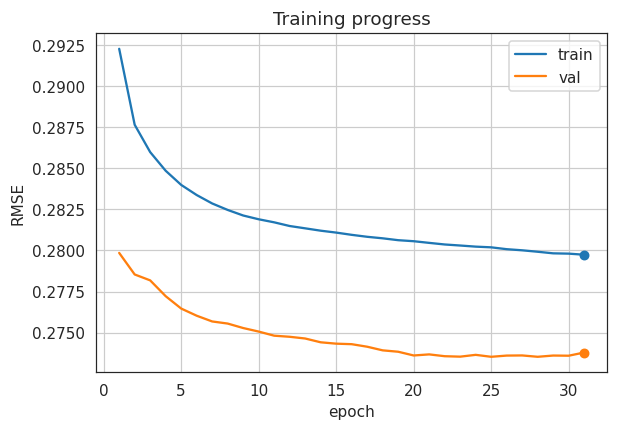

In [11]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")

